# Dog Skin Diseases Classification

The notebook incorporates the model utilized for classifying skin diseases of dogs (3 diseases and 1 healthy class). A customley made datasetspecially for Sri Lanka is used for training, validating and testing the model. The development of the classification model followed a transfer learning approach, using ResNet50 Keras application. To assess the performance of the model, several evaluation metrics were employed, including accuracy, F1-score, precision, recall, and evaluation matrix. The output from each metric indicates that the model achieved a high level of accuracy in classifying the eye images.


### Importing required libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [2]:
# Set dataset path
TRAIN_PATH = r'E:\Year04\IRP\dataset\organized_data\train'
VAL_PATH = r'E:\Year04\IRP\dataset\organized_data\val'
TEST_PATH = r'E:\Year04\IRP\dataset\organized_data\test'

In [3]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

### Initializing train, validation & test data

In [4]:
# Data Generators
train_gen = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    VAL_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1757 images belonging to 4 classes.
Found 501 images belonging to 4 classes.
Found 255 images belonging to 4 classes.


### Plot Images with labels

In [5]:
# Get class labels
class_labels = list(train_gen.class_indices.keys())
print("Class Labels:", class_labels)

Class Labels: ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']


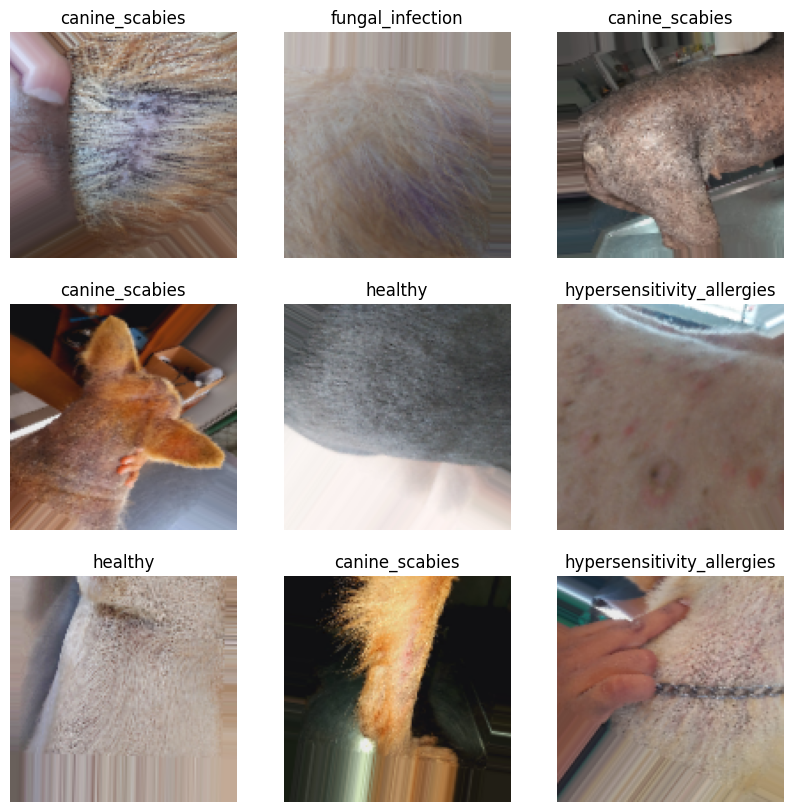

In [6]:
# Visualize Some Images
def visualize_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

visualize_images(train_gen)

ResNet50


In [7]:
# Model Initialization
ResNet_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

In [8]:
model = Sequential([
    ResNet_model,
    GlobalAveragePooling2D(),
    Dense(units=512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [9]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [10]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, patience=3, min_lr=0.0001)
checkpoint = ModelCheckpoint('resnet152v2_best_model.h5', monitor='val_accuracy', save_best_only=True)


In [11]:
# Training
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30
55/55 [==============================] - ETA: 0s - loss: 1.2095 - accuracy: 0.4883 - precision: 0.5922 - recall: 0.2521

c:\anaconda\envs\gpu_py\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


55/55 [==============================] - 457s 8s/step - loss: 1.2095 - accuracy: 0.4883 - precision: 0.5922 - recall: 0.2521 - val_loss: 5.5557 - val_accuracy: 0.4511 - val_precision: 0.4536 - val_recall: 0.4491 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - 355s 6s/step - loss: 0.9429 - accuracy: 0.6306 - precision: 0.7415 - recall: 0.4701 - val_loss: 1.6743 - val_accuracy: 0.5968 - val_precision: 0.6116 - val_recall: 0.5689 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - 427s 8s/step - loss: 0.8654 - accuracy: 0.6670 - precision: 0.7559 - recall: 0.5270 - val_loss: 1.3268 - val_accuracy: 0.5888 - val_precision: 0.6386 - val_recall: 0.5150 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - 319s 6s/step - loss: 0.7885 - accuracy: 0.7029 - precision: 0.7817 - recall: 0.6033 - val_loss: 1.3410 - val_accuracy: 0.6188 - val_precision: 0.6658 - val_recall: 0.5369 - lr: 0.0010
Epoch 5/30
55/55 [==============================] - 362s 7s/step - 

In [15]:
# Save Final Model
model.save('resnet152v2_dog_skin_disease.h5')

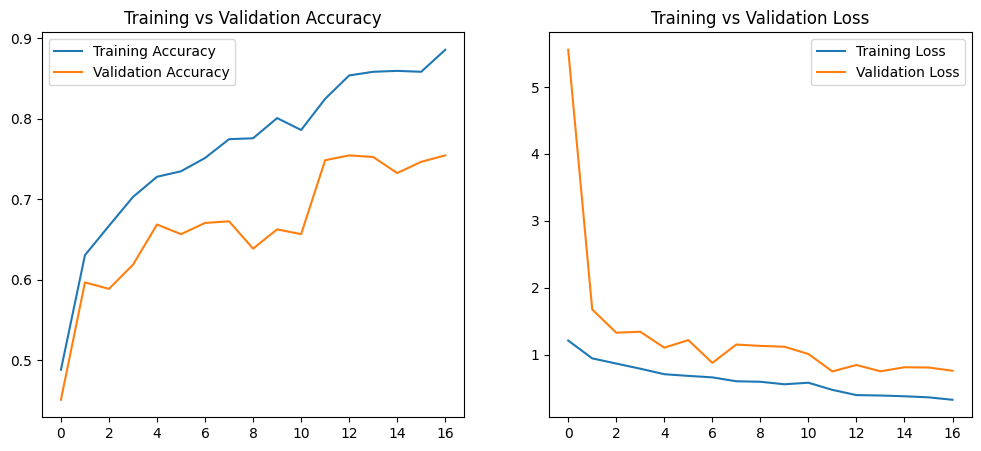

In [18]:
# Evaluation
# Plot Training vs Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] , label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [21]:
from keras.models import load_model

# Load the saved model
saved_model = load_model('resnet152v2_best_model.h5')

# Evaluate on training data
train_results = saved_model.evaluate(train_gen, verbose=0)
print(f"Training - Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]*100:.2f}%, Precision: {train_results[2]*100:.2f}%, Recall: {train_results[3]*100:.2f}%")

# Evaluate on validation data
val_results = saved_model.evaluate(val_gen, verbose=0)
print(f"Validation - Loss: {val_results[0]:.4f}, Accuracy: {val_results[1]*100:.2f}%, Precision: {val_results[2]*100:.2f}%, Recall: {val_results[3]*100:.2f}%")

# Evaluate on test data
test_results = saved_model.evaluate(test_gen, verbose=0)
print(f"Test - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]*100:.2f}%, Precision: {test_results[2]*100:.2f}%, Recall: {test_results[3]*100:.2f}%")


Training - Loss: 0.3515, Accuracy: 87.14%, Precision: 89.17%, Recall: 84.80%
Validation - Loss: 0.8323, Accuracy: 72.46%, Precision: 75.65%, Recall: 69.46%
Test - Loss: 0.8689, Accuracy: 75.69%, Precision: 77.18%, Recall: 72.94%


In [23]:
prediction_effnet = saved_model.predict(test_gen) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

In [26]:
true_labels = []

# Iterate only through the number of batches
for i in range(len(test_gen)):
    image_batch, label_batch = test_gen[i]
    true_labels.append(label_batch)

# Concatenate and convert to numpy
correct_labels = tf.concat(true_labels, axis=0).numpy()


In [27]:
print(type(prediction_effnet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
from sklearn.metrics import classification_report
import numpy as np

# Convert one-hot encoded labels to class indices if needed
if correct_labels.ndim > 1:
    correct_labels = np.argmax(correct_labels, axis=1)

# Convert predictions to class indices if they are probabilities
if prediction_effnet.ndim > 1:
    prediction_effnet = np.argmax(prediction_effnet, axis=1)

# Ensure both arrays are integers
correct_labels = correct_labels.astype(int)
prediction_effnet = prediction_effnet.astype(int)

# Generate Classification Report
print(classification_report(correct_labels, prediction_effnet))


              precision    recall  f1-score   support

           0       0.70      0.81      0.75        67
           1       0.76      0.60      0.67        70
           2       0.79      0.87      0.83        67
           3       0.78      0.76      0.77        51

    accuracy                           0.76       255
   macro avg       0.76      0.76      0.76       255
weighted avg       0.76      0.76      0.75       255



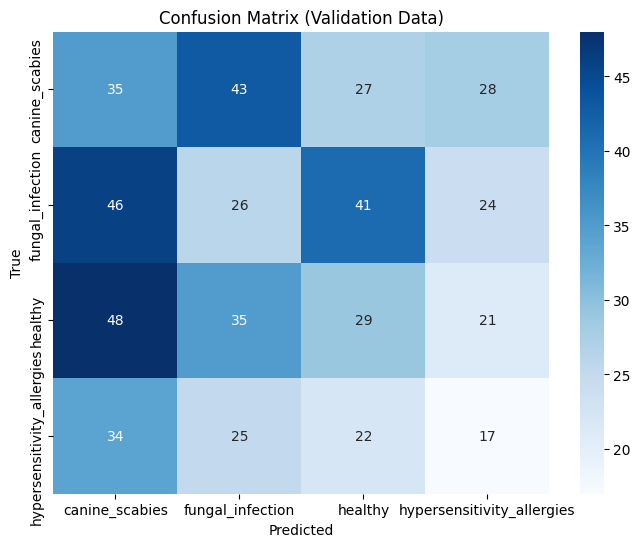

                            precision    recall  f1-score   support

            canine_scabies       0.21      0.26      0.24       133
          fungal_infection       0.20      0.19      0.20       137
                   healthy       0.24      0.22      0.23       133
hypersensitivity_allergies       0.19      0.17      0.18        98

                  accuracy                           0.21       501
                 macro avg       0.21      0.21      0.21       501
              weighted avg       0.21      0.21      0.21       501



In [22]:
# Confusion Matrix and Classification Report (Validation Data)
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.title('Confusion Matrix (Validation Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=list(val_gen.class_indices.keys())))


In [ ]:
# Test Accuracy
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
